# Project 2 - Ames Housing Data and Kaggle Challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import pickle

from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

### Load the data

In [2]:
train_df = pickle.load(open('../datasets/pickled_train.csv', 'rb'))
test_df = pickle.load(open('../datasets/pickled_test.csv', 'rb'))

In [3]:
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
0,109,533352170,60,RL,68.0,13517,Pave,IR1,Lvl,AllPub,...,1,0,0,1,0,0,0,0,0,1
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,1,0,0,0,1,0,0,0,0,1
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,0,1,0,1,0,0,0,0,0,1
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,0,1,0,0,1,0,0,0,0,1
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,0,1,0,0,1,0,0,0,0,1


In [4]:
test_df.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
0,2658,902301120,190,RM,69.0,9142,Pave,Reg,Lvl,AllPub,...,0,1,0,0,0,1,0,0,0,1


In [5]:
print(train_df.shape)
print(test_df.shape)

(1949, 133)
(879, 131)


## 4 Modeling

### Model Prep: Create our features matrix (`X`) and target vector (`y`)

#### 4.1 Regression models
#### Baseline Feature: 16 variables that are considered intuitively important when buying house

In [6]:
feature_base = ['Lot Area', 'Gr Liv Area','age','central_aircon','hse_cond','Garage Cars',\
                'fireplace_qu_num','Fireplaces','Bedroom AbvGr','total_baths',\
               'kitchen_qual_num','bsmt_cond_num','artery_st','feeder_st','railroad','park'] 
print(len(feature_base))

16


In [7]:
X_train = train_df[feature_base]
X_test = test_df[feature_base]
y_train = train_df['SalePrice']    # target is your dependant variable

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1949, 16)
(879, 16)
(1949,)


#### 2nd Feature set
* 51 features were selected from corr() results, and visual inspection of group distribuion in categorical variables.
* They were first fed in lasso regression to eliminate redundant  variables, 11 variables were removed, remaining 40 features were fed through various regression method.
* Removed variables: zoning_RL, House Style_2.5Fin, Land Contour_HLS, House Style_2.5Unf,'Foundation_CBlock','Foundation_PConc','Foundation_Stone',,'Foundation_Wood', 'House Style_SFoyer','House Style_SLvl',\

#### 40 Features
features = ['Overall Qual',
'exter_qual_num',
'hse_cond',
'age',
'age_remod',
'Gr Liv Area',
'1st Flr SF',
'Lot Area',
'Lot Frontage',
'Open Porch SF',
'Wood Deck SF',
'kitchen_qual_num',
'fireplace_qu_num',
'Fireplaces',
'Garage Area',
'Garage Cars',
'total_baths',
'TotRms AbvGrd',
'Mas Vnr Area',
'Total Bsmt SF',
'BsmtFin SF 1',
'artery_st','feeder_st','railroad','park','central_aircon',\
'zoning_FV','zoning_RM',\
'Bldg Type_2fmCon','Bldg Type_Duplex','Bldg Type_Twnhs','Bldg Type_TwnhsE','House Style_1.5Unf','House Style_1Story',\
'House Style_2Story',
'Mas Vnr Type_BrkFace','Mas Vnr Type_None','Mas Vnr Type_Stone','Land Contour_Low','Land Contour_Lvl']

In [8]:
#### 30 features
features = ['Gr Liv Area', 'Mas Vnr Type_None', 'Total Bsmt SF', 'Overall Qual',\
       'age', 'BsmtFin SF 1', 'Mas Vnr Type_Stone', 'hse_cond',\
       'Mas Vnr Type_BrkFace', 'Mas Vnr Area', 'kitchen_qual_num',\
       'exter_qual_num', 'Garage Area', 'Lot Area', 'fireplace_qu_num',\
       'Bldg Type_Duplex', 'Land Contour_Lvl', 'Bldg Type_TwnhsE',\
       'total_baths', '1st Flr SF']

#### 20 features
features = ['Gr Liv Area', 'Mas Vnr Type_None', 'Total Bsmt SF', 'Overall Qual',\
       'BsmtFin SF 1', 'age', 'Mas Vnr Type_Stone', 'Mas Vnr Area', 'hse_cond',\
       'Mas Vnr Type_BrkFace', 'exter_qual_num', 'kitchen_qual_num',\
       'Lot Area', 'Land Contour_Lvl', 'Garage Area', '1st Flr SF',\
       'Bldg Type_Duplex', 'total_baths', 'Bldg Type_TwnhsE','fireplace_qu_num']
len(features)

In [9]:
X_train2 = train_df[features]
X_test2 = test_df[features]
y_train = train_df['SalePrice']  

print(X_train2.shape)
print(X_test2.shape)
print(y_train.shape)

(1949, 20)
(879, 20)
(1949,)


### Model Prep: Scaling

In [10]:
# fit a `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

# for baseline features
ss = StandardScaler()
ss.fit(X_train)                       # use train testset to peform standardization fit
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)  # use statistcs obtained from *train* set to transform the test set

In [11]:
# For feature set 2

ss2 = StandardScaler()
ss2.fit(X_train2)                       # use train testset to peform standardization fit
X_train_sc2 = ss2.transform(X_train2)
X_test_sc2 = ss2.transform(X_test2)  # use statistcs obtained from *train* set to transform the test set

### Model Prep: Instantiate our models and Fit the models

In [12]:
# For baseline features
lr1 = LinearRegression()
lr1.fit(X_train_sc,y_train)
print('LR intercept and coef: ',lr1.intercept_,lr1.coef_)

l_alphas = np.arange(0.01,0.5,0.02)
lasso = LassoCV(alphas = l_alphas,cv=5)
lasso.fit(X_train_sc,y_train)
print('lasso alpha and coef: ', lasso.alpha_, lasso.coef_)

ridge = RidgeCV(alphas=np.logspace(0, 3, 100), cv=5)
ridge.fit(X_train_sc,y_train)
print('ridge alpha: ',ridge.alpha_, ridge.coef_)

enet_alphas = np.arange(0.5, 1.0, 0.005)
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=0.5, cv=5)
enet.fit(X_train_sc,y_train)
print('enet alpha and coef: ', enet.alpha_, enet.coef_)   #  the optimal value

LR intercept and coef:  183859.24935864544 [  8849.0403505   42833.25609207 -21663.30636991  -2301.26274962
  17468.41967549   8511.24671121   4119.86180756   1565.05601011
  -7672.20496353 -11734.92366966  11164.89293143  -1078.12830158
  -1761.61970347  -1272.30899916  -2451.92037624   3372.22149882]
lasso alpha and coef:  0.48999999999999994 [  8848.78856242  42831.02135399 -21661.76907484  -2300.33356633
  17467.8645247    8511.1852364    4120.30271901   1564.76389897
  -7671.63919843 -11732.28364652  11165.2425865   -1077.42571639
  -1761.14135711  -1271.78411549  -2451.54580518   3371.88310313]
ridge alpha:  16.297508346206442 [  8878.72685073  41360.98603734 -20983.15969108  -2189.99163061
  17342.14096813   8736.94514544   4219.88190948   1788.24249626
  -7329.0645685  -10686.46642499  11474.8400038   -1037.09316258
  -1773.62099775  -1251.38372305  -2450.97291533   3384.23479158]
enet alpha and coef:  0.5 [  8403.84724204  23933.0610565  -13316.02768337   -421.94999024
  14930

In [13]:
# For feature set 2
lr2 = LinearRegression()
lr2.fit(X_train_sc2,y_train)
print('LR2 intercept and coef: ',lr2.intercept_, lr2.coef_)

l_alphas = np.arange(0.01,10,0.02)
lasso2 = LassoCV(alphas = l_alphas,cv=5)
lasso2.fit(X_train_sc2,y_train)
print('lasso alpha and coef: ', lasso2.alpha_, lasso2.coef_)

ridge2 = RidgeCV(alphas=np.logspace(0, 3, 100), cv=5)
ridge2.fit(X_train_sc2,y_train)
print('ridge2 alpha: ',ridge2.alpha_, ridge2.coef_)

enet2_alphas = np.arange(0, 10.0, 0.05)
enet2 = ElasticNetCV(alphas=enet2_alphas, l1_ratio=0.5, cv=5)
enet2.fit(X_train_sc2,y_train)
print('enet2 alpha and coef: ', enet2.alpha_, enet2.coef_)   #  the optimal value

LR2 intercept and coef:  183859.24935864547 [ 26046.64470384  16107.53337403  11256.41146867  10671.06163008
 -10595.05526656  10097.46833322   9699.8305471    9482.45770533
   9400.99258757   9056.07509952   6467.96880486   6311.0374155
   5460.97714955   5168.35566308   3576.28670013  -3420.59307224
  -3203.4793597   -2899.70702944  -2351.95896971    159.33083529]
lasso alpha and coef:  0.01 [ 26046.60112904  16106.46045074  11256.41798792  10671.06539733
 -10595.01204783  10097.47373725   9699.22384624   9482.45164742
   9399.99055194   9056.05235786   6467.97910341   6311.04084606
   5460.98405168   5168.32166799   3576.28386844  -3420.58691772
  -3203.47928041  -2899.70007762  -2351.89443653    159.33654578]
ridge2 alpha:  1.0 [ 25989.11024712  15485.15029731  11230.87269757  10675.25176596
 -10564.24674167  10099.08304182   9345.86248498   9474.91722281
   8820.03928843   9045.23756457   6478.32103941   6321.34480911
   5469.93282021   5149.42990594   3581.25116481  -3418.8843293

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 504259235272.0967, tolerance: 971023478.0650643
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557125293614.1553, tolerance: 977781879.316457
  tol, rng, random, positive)
C

enet2 alpha and coef:  0.0 [ 26046.64470389  16107.53337041  11256.41146885  10671.06163017
 -10595.05526658  10097.46833325   9699.83054507   9482.45770533
   9400.99258423   9056.07509941   6467.96880487   6311.03741546
   5460.97714954   5168.35566298   3576.28670012  -3420.59307223
  -3203.47935973  -2899.70702946  -2351.95896973    159.33083511]


C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561139574068.9717, tolerance: 983890752.1681086
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515616777108.59863, tolerance: 933218890.92202
  tol, rng, random, positive)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1227: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  mode

* ElasticNet returns ConvergenceWarning: Objective did not converge with feature no at 20 
* lasso also returns similar warning when the features reduced below 30. 

Will stop reducing features at 30 features, will not consider Elasticnet's model.

#### Look at the coeficient across all models

In [14]:
# Construct a coef dataframe for all models and plot it on the graph

lr_coef_df = pd.DataFrame(lr1.coef_, index=feature_base, columns=['coefficients'])
lasso_coef_df = pd.DataFrame(lasso.coef_, index=feature_base, columns=['coefficients'])
ridge_coef_df = pd.DataFrame(ridge.coef_, index=feature_base, columns=['coefficients'])
enet_coef_df = pd.DataFrame(enet.coef_, index=feature_base, columns=['coefficients'])

coef = pd.concat([lr_coef_df,lasso_coef_df,ridge_coef_df,enet_coef_df])
coef.reset_index(inplace=True)

In [15]:
# for feature set 2
lr2_coef_df = pd.DataFrame(lr2.coef_, index=features, columns=['coefficients'])
lasso2_coef_df = pd.DataFrame(lasso2.coef_, index=features, columns=['coefficients'])
ridge2_coef_df = pd.DataFrame(ridge2.coef_, index=features, columns=['coefficients'])

coef2 = pd.concat([lr2_coef_df,lasso2_coef_df,ridge2_coef_df])
coef2.reset_index(inplace=True)

In [16]:
coef.loc[0:16,'model'] = 'lr'
coef.loc[16:32,'model'] = 'lasso'
coef.loc[32:48,'model'] = 'ridge'
coef.loc[48:64,'model'] = 'enet'

coef2.loc[0:len(lr2.coef_),'model'] = 'lr'
coef2.loc[len(lr2.coef_):len(lr2.coef_)*2,'model'] = 'lasso'
coef2.loc[len(lr2.coef_)*2:len(lr2.coef_)*3,'model'] = 'ridge'

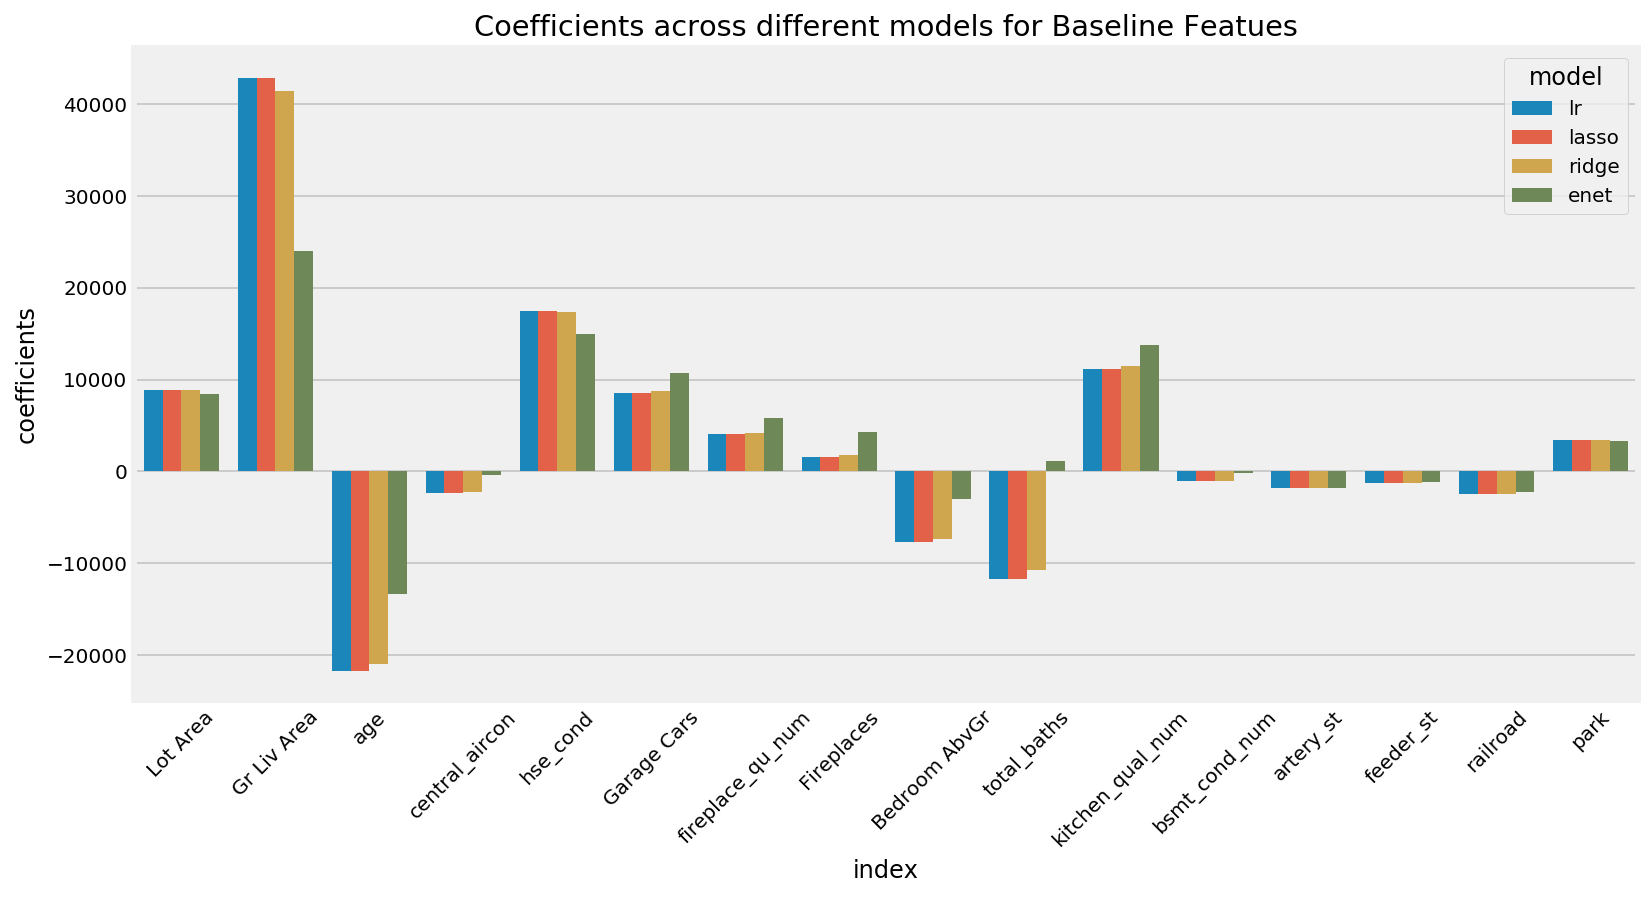

In [17]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot('index','coefficients',hue='model',data=coef)
ax.set_xticklabels(X_train.columns,rotation=45)
ax.set_title('Coefficients across different models for Baseline Featues')
plt.savefig('../images/models_coef_baseline.png')

* All models produced similar coefs, although elasticnet regression placed less emphysis on `'Gr Liv Area'` and `'age'`, and more on `'kitchen_qu_num'`
* No variables are eliminated by lasso regression
* The key variables that contributes to *higher* sale price are: `'Gr Liv Area`',`'hse_cond'`, `'kitchen_qu_num'`, followed by `'Lot Area'` and `'Garage Cars'`, this is common in all models
* Variabels that would affect sale price *negatively* are: `age`,and `'total_baths'` and `'Bedroom AgvGr'`, the latter two are unexpected, as we normally think that the more rooms/bathrooms, the better.


Text(0.5, 1.0, 'Lasso Regression Coefficients - Feature Set 2')

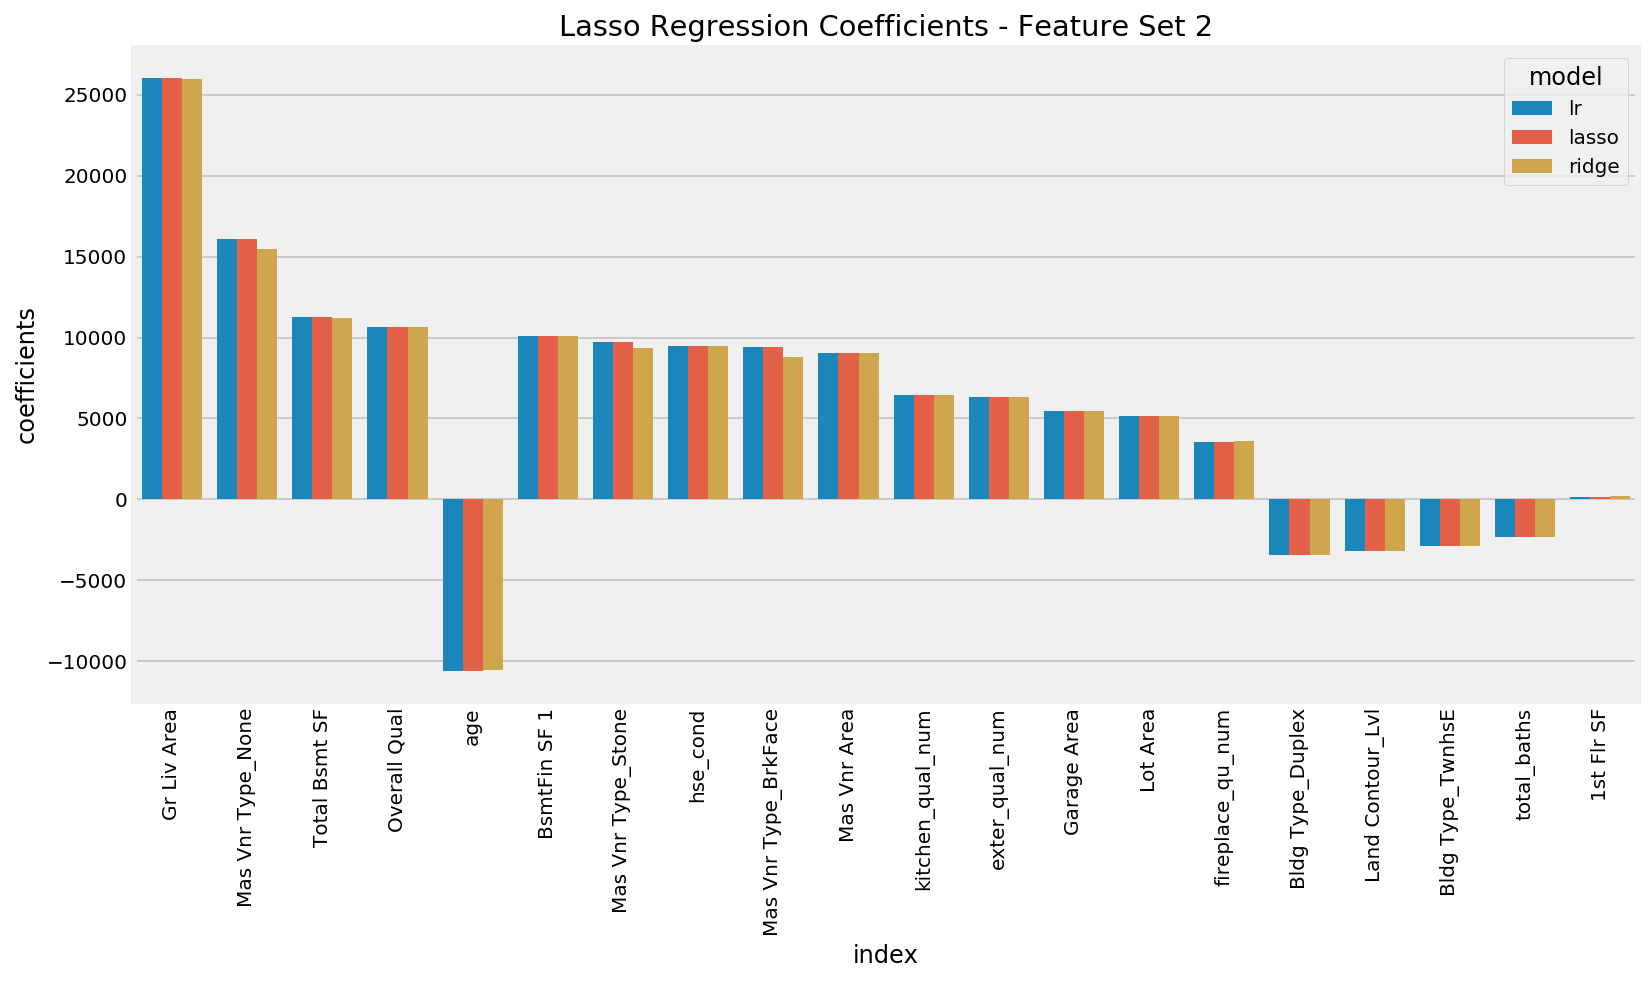

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot('index','coefficients',hue='model',data=coef2)
ax.set_xticklabels(X_train2.columns,rotation=90)
ax.set_title('Coefficients across different models for Featue set2')
ax.set_title('Lasso Regression Coefficients - Feature Set 2')

In [19]:
# Observation:
## 50 features: 3 variables are zeroed by lasso.  zoning_RL, House Style_2.5Fin, Land Contour_HLS
##  47 features: House Style_2.5Unf is nearly zeroed
## at 46 features, lasso is *not* able to further reduce anymore variables
## the features further reduced to 20 choosing the top 20.

In [20]:
abs(lr2_coef_df).sort_values('coefficients',ascending=False).index[0:30]

Index(['Gr Liv Area', 'Mas Vnr Type_None', 'Total Bsmt SF', 'Overall Qual',
       'age', 'BsmtFin SF 1', 'Mas Vnr Type_Stone', 'hse_cond',
       'Mas Vnr Type_BrkFace', 'Mas Vnr Area', 'kitchen_qual_num',
       'exter_qual_num', 'Garage Area', 'Lot Area', 'fireplace_qu_num',
       'Bldg Type_Duplex', 'Land Contour_Lvl', 'Bldg Type_TwnhsE',
       'total_baths', '1st Flr SF'],
      dtype='object')

### Cross validation  with cross_val_score() to evaluate all modules

In [21]:
# for baseline features
lr1_r2_scores = cross_val_score(lr1,X_train_sc,y_train,cv=5)
print(lr1_r2_scores.mean())
lasso_scores = cross_val_score(lasso,X_train_sc,y_train,cv=5)
print(lasso_scores.mean())
ridge_scores = cross_val_score(ridge,X_train_sc,y_train,cv=5)
print(ridge_scores.mean())
enet_scores = cross_val_score(enet,X_train_sc,y_train,cv=5, scoring='r2')
print(enet_scores.mean())

0.8230414849935975
0.8230426757736862
0.8232060665455576
0.8066884287071131


In [25]:
# for Features set 2
lr2_r2_scores = cross_val_score(lr2,X_train_sc2,y_train,cv=5)
print(lr2_r2_scores.mean())
lasso2_scores = cross_val_score(lasso2,X_train_sc2,y_train,cv=5)
print(lasso_scores.mean())
ridge2_scores = cross_val_score(ridge2,X_train_sc2,y_train,cv=5)
print(ridge_scores.mean())

0.8798620755441716
0.8230426757736862
0.8232060665455576


**Baseline feature: the R2 scores are in the 0.80 range. ElasticNet scored lowest, while the other 3 models are comparable 
**Feature set 2: linear regression has the highest R2 value  -> linear regression is chosen

### Visualize / Evaluate the results

In [26]:
y_pred_lr = lr1.predict(X_train_sc)
residuals_lr = y_train - y_pred_lr

y_pred_lasso = lasso.predict(X_train_sc)
residuals_lasso = y_train - y_pred_lasso

y_pred_ridge = ridge.predict(X_train_sc)
residuals_ridge = y_train - y_pred_ridge

y_pred_enet = enet.predict(X_train_sc)
residuals_enet = y_train - y_pred_enet

Text(0.5, 1.0, 'Actual vs. Predicted Sale Price (LinearRegression)')

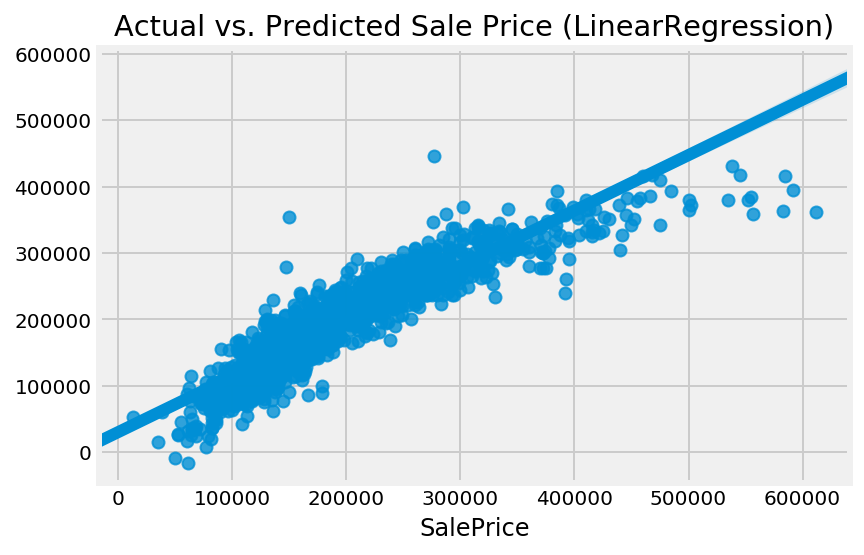

In [28]:
sns.regplot(y_train,y_pred_lr)
plt.title('Actual vs. Predicted Sale Price (LinearRegression)')

On the two extreme ends of the sale price, our model will *under-estimate* the sale price

Text(0.5, 1.0, 'Actual vs. Predicted Sale Price (Feature Set 2)')

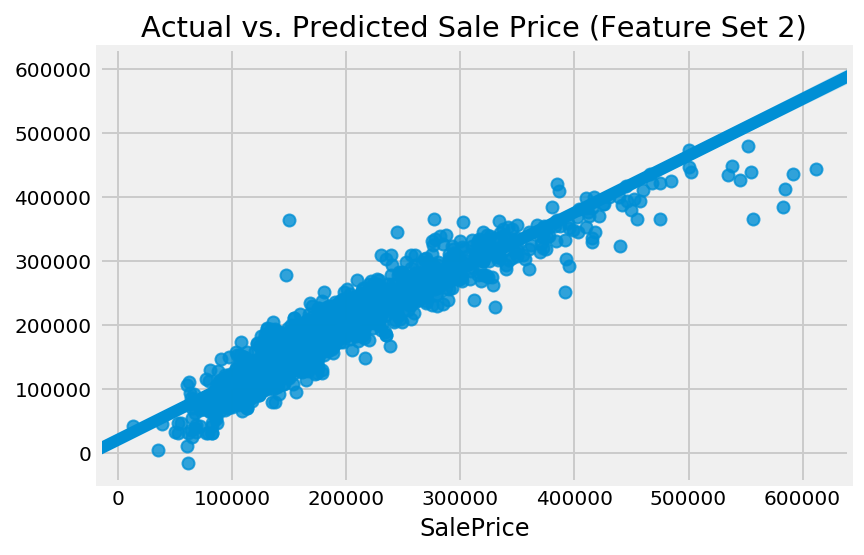

In [32]:
# A quick comparison with Features set 2
# features set 2: do not observe obvious improvement based on Actual vs Predicted Sale Price.
# The two ends of the scale: we still have under-estimation problem.
#
y_pred_lr2 = lr2.predict(X_train_sc2)
residuals_lr2 = y_train - y_pred_lr2
sns.regplot(y_train,y_pred_lr2)
plt.title('Actual vs. Predicted Sale Price (Feature Set 2)')

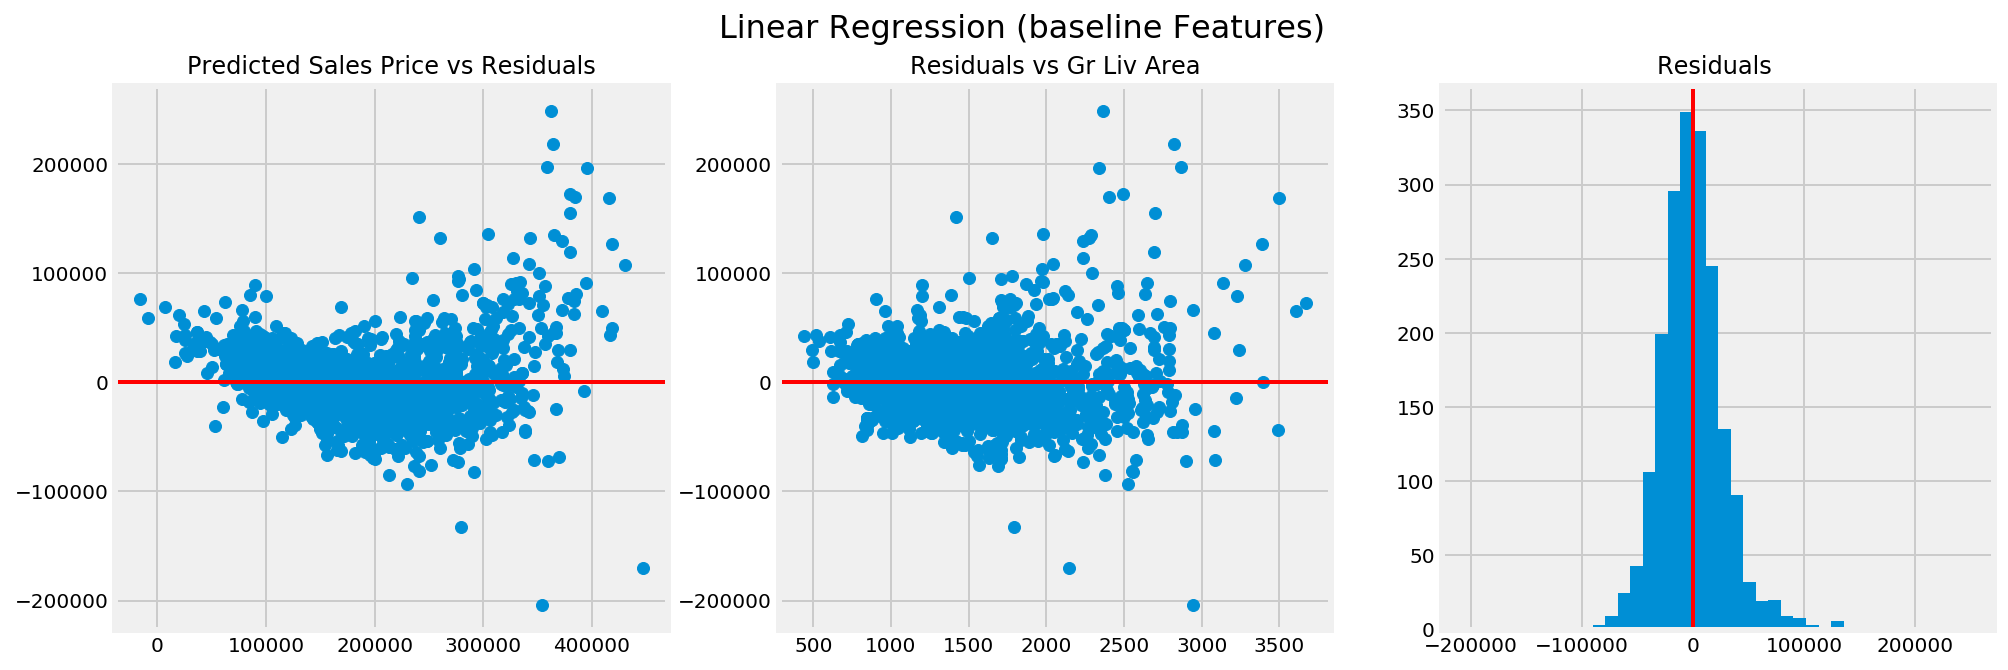

In [31]:
# Linear Regression on baseline features
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter (y_pred_lr,residuals_lr)
ax[0].set_title('Predicted Sales Price vs Residuals', fontsize=12)
ax[0].axhline(0, c='r',linewidth=2)
ax[1].scatter (y=residuals_lr,x=train_df['Gr Liv Area'])
ax[1].set_title('Residuals vs Gr Liv Area', fontsize=12)
ax[1].axhline(0, c='r',linewidth=2)
ax[2].hist(residuals_lr,bins=40)
ax[2].set_title('Residuals ', fontsize=12)
ax[2].axvline(0, c='r',linewidth=2)
plt.suptitle('Linear Regression (baseline Features)',fontsize=16)
plt.savefig('../images/residuals_baseline_lr.png')

* The residual plot displays heteroscedasticity, larger houses have wider price variance
* Price prediction in the mid size range would be very close the actual sales price
* The predicted price for very small or very large houses will tend to be under estimated.
* The residual distribution is close to normal.

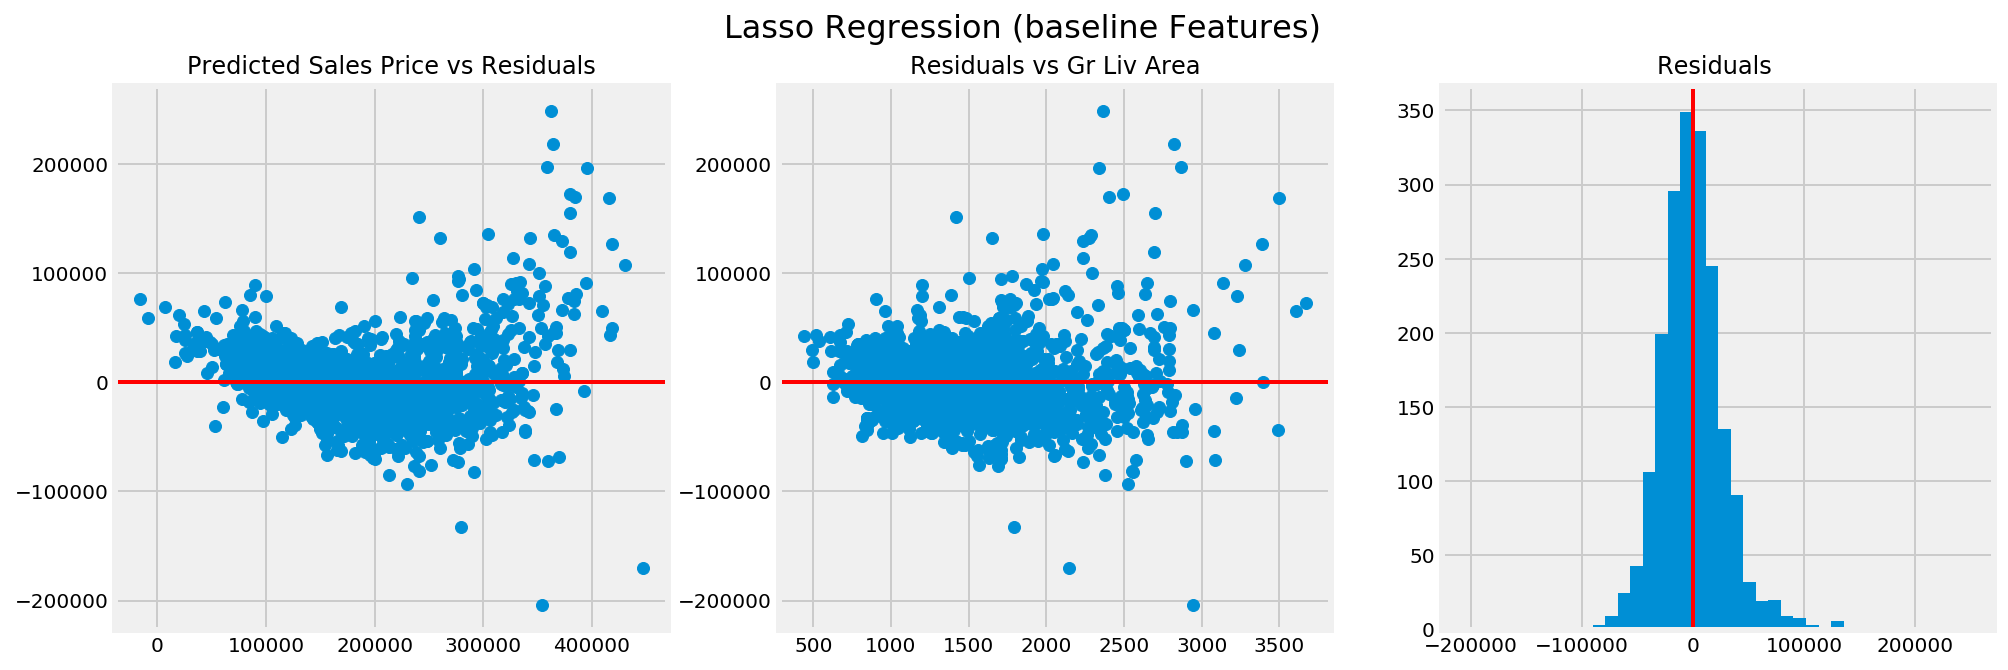

In [33]:
#Regression
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter (y_pred_lasso,residuals_lasso)
ax[0].set_title('Predicted Sales Price vs Residuals', fontsize=12)
ax[0].axhline(0, c='r',linewidth=2)
ax[1].scatter (y=residuals_lasso,x=train_df['Gr Liv Area'])
ax[1].set_title('Residuals vs Gr Liv Area', fontsize=12)
ax[1].axhline(0, c='r',linewidth=2)
ax[2].hist(residuals_lasso,bins=40)
ax[2].set_title('Residuals ', fontsize=12)
ax[2].axvline(0, c='r',linewidth=2)
plt.suptitle('Lasso Regression (baseline Features)',fontsize=16)
plt.savefig('../images/residuals_baseline_lasso.png')

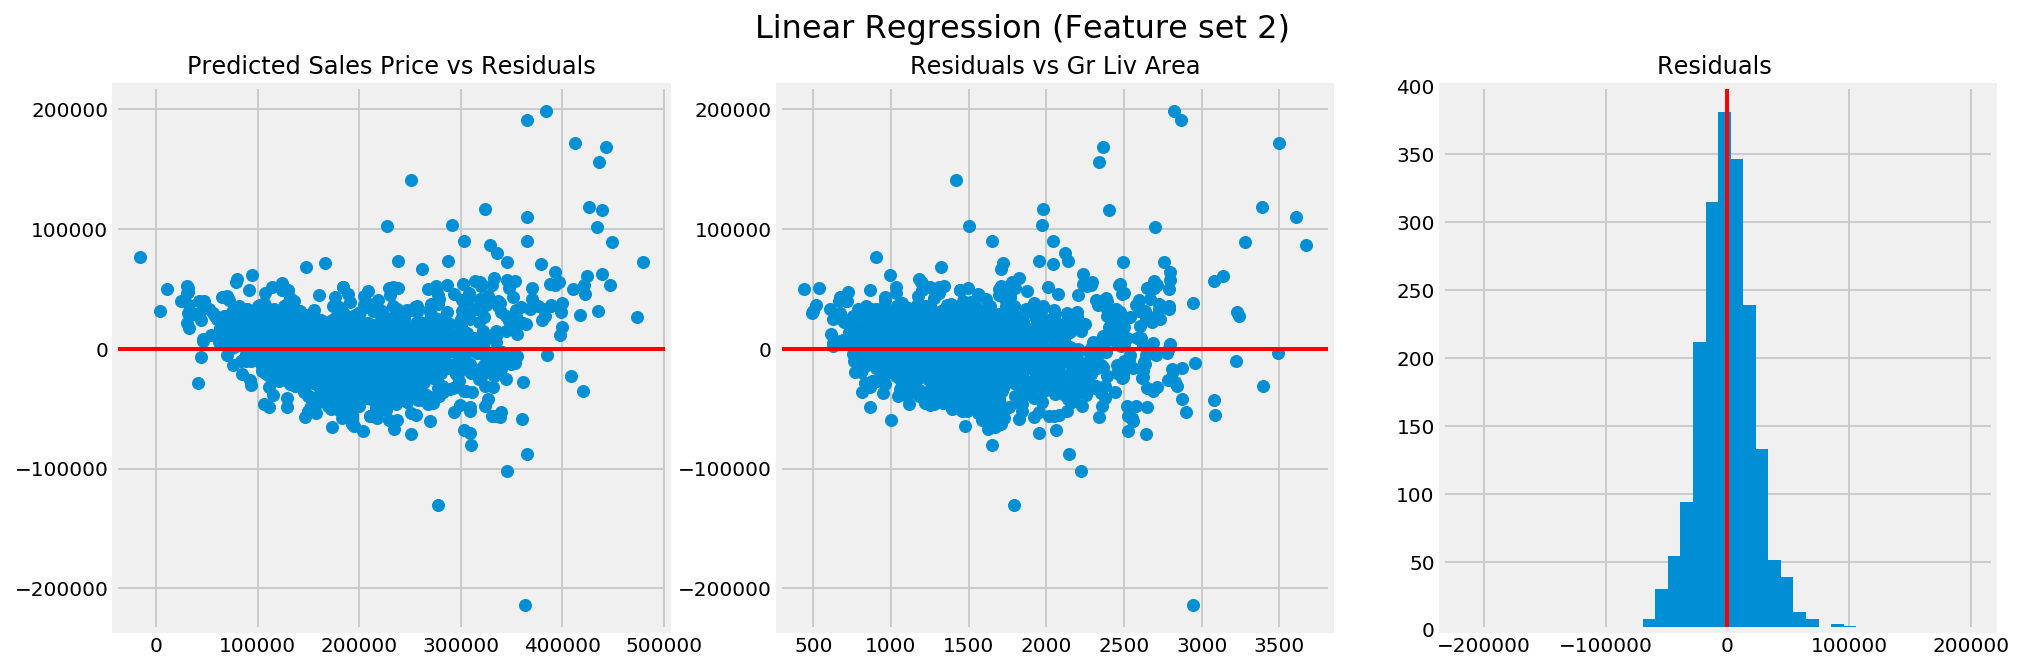

In [35]:
# Linear Regression on feature set 2
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter (y_pred_lr2,residuals_lr2)
ax[0].set_title('Predicted Sales Price vs Residuals', fontsize=12)
ax[0].axhline(0, c='r',linewidth=2)
ax[1].scatter (y=residuals_lr2,x=train_df['Gr Liv Area'])
ax[1].set_title('Residuals vs Gr Liv Area', fontsize=12)
ax[1].axhline(0, c='r',linewidth=2)
ax[2].hist(residuals_lr2,bins=40)
ax[2].set_title('Residuals ', fontsize=12)
ax[2].axvline(0, c='r',linewidth=2)
plt.suptitle('Linear Regression (Feature set 2)',fontsize=16)
plt.savefig('../images/residuals_feature_set2_lr.png')

In [ ]:
**Observation**
* no much improvment is seen with 30 features on the residual plot
* underestimation in very small or very large properties too.
* residual distribution is also close to normal.

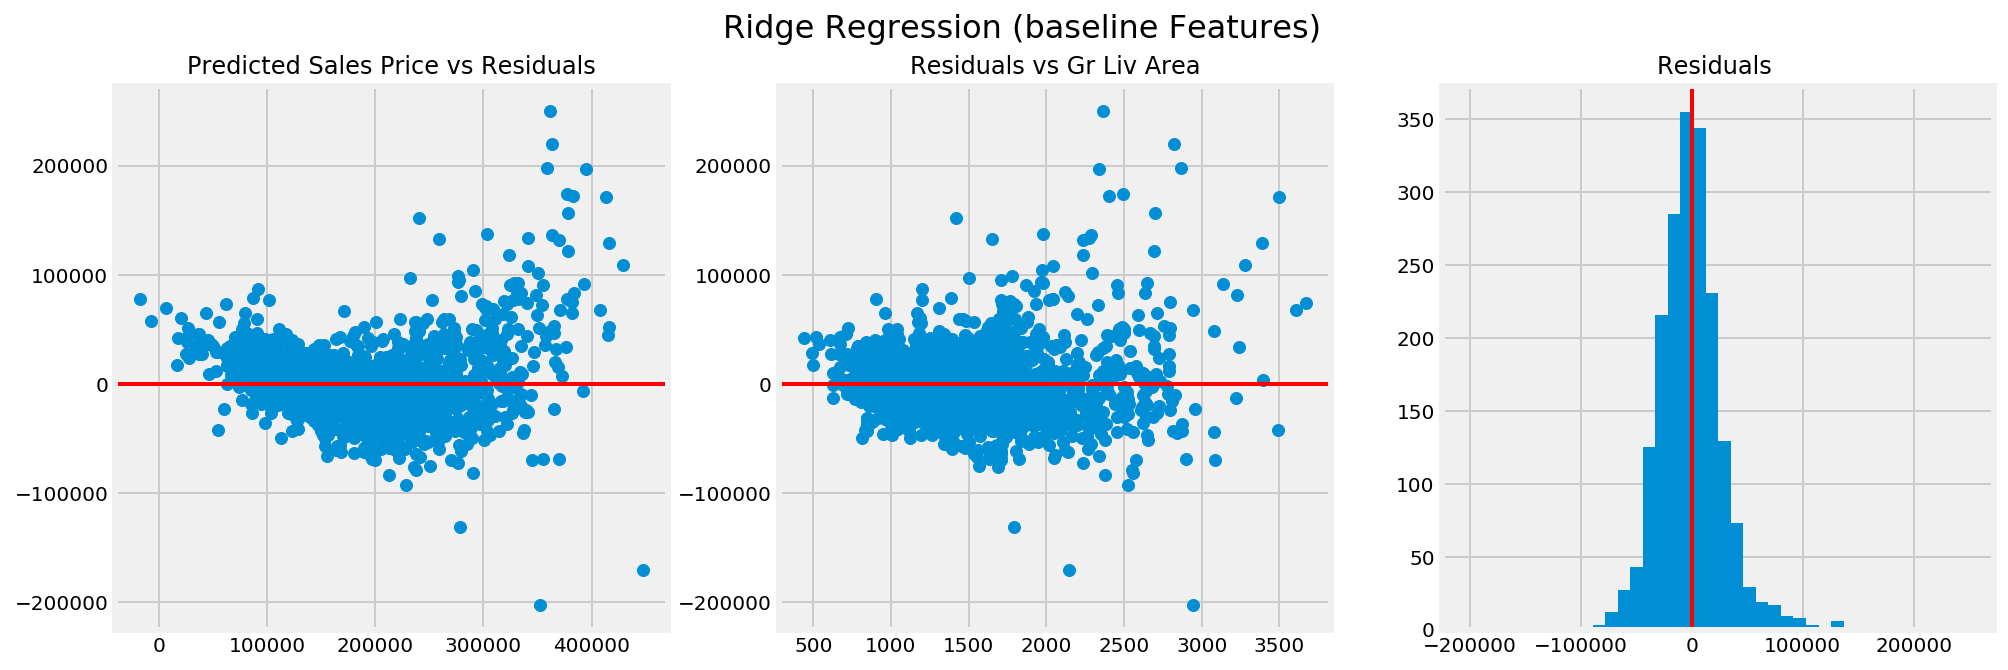

In [34]:
# Ridge Regression
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter (y_pred_ridge,residuals_ridge)
ax[0].set_title('Predicted Sales Price vs Residuals', fontsize=12)
ax[0].axhline(0, c='r',linewidth=2)
ax[1].scatter (y=residuals_ridge,x=train_df['Gr Liv Area'])
ax[1].set_title('Residuals vs Gr Liv Area', fontsize=12)
ax[1].axhline(0, c='r',linewidth=2)
ax[2].hist(residuals_ridge,bins=40)
ax[2].set_title('Residuals ', fontsize=12)
ax[2].axvline(0, c='r',linewidth=2)
plt.suptitle('Ridge Regression (baseline Features)',fontsize=16)
plt.savefig('../images/residuals_baseline_ridge.png')

In [ ]:
# ElasticNet
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter (y_pred_enet,residuals_enet)
ax[0].set_title('Predicted Sales Price vs Residuals', fontsize=12)
ax[0].axhline(0, c='r',linewidth=2)
ax[1].scatter (y=residuals_enet,x=train_df['Gr Liv Area'])
ax[1].set_title('Residuals vs Gr Liv Area', fontsize=12)
ax[1].axhline(0, c='r',linewidth=2)
ax[2].hist(residuals_enet,bins=40)
ax[2].set_title('Residuals ', fontsize=12)
ax[2].axvline(0, c='r',linewidth=2)
plt.suptitle('ElasticNet Regression (baseline Features)',fontsize=16)
plt.savefig('../images/residuals_baseline_enet.png')

#### With baseline features: the residual plot and residual distrubtion are very similar among among all four models with the baseline features.

Since the scores and the residuals are comparable, linear regression model will be apply to the test data

### Fit Linear Regression Model to Test Data

In [36]:
y_pred_lr_test = lr1.predict(X_test_sc)

len(y_pred_lr_test),len(X_test)

(879, 879)

In [38]:
df_pred_test = pd.DataFrame(y_pred_lr_test, index=list(test_df['Id']), columns = ['SalePrice'])

df_pred_test.reset_index(inplace=True)
df_pred_test.rename(columns = {'index': 'Id'},inplace=True)
df_pred_test.head()

,Id,SalePrice
0,2658,134390.273193
1,2718,159061.934185
2,2414,223318.080570
3,1989,110736.859411
4,625,163947.415223


In [39]:
# Save the predicted variables in csv
df_pred_test.to_csv('../datasets/baseline_prediction.csv',index=False)

In [40]:
# For feature set 2
y_pred_lr2 = lr2.predict(X_test_sc2)
df_pred2_test = pd.DataFrame(y_pred_lr2, index=list(test_df['Id']), columns = ['SalePrice'])

df_pred2_test.reset_index(inplace=True)
df_pred2_test.rename(columns = {'index': 'Id'},inplace=True)
df_pred2_test.head()

,Id,SalePrice
0,2658,147070.197602
1,2718,171220.144093
2,2414,212107.864234
3,1989,114106.327879
4,625,177122.660042


In [41]:
# Save the predicted variables in csv
df_pred2_test.to_csv('../datasets/features2_prediction.csv',index=False)

## Conclusions and Recommendations

The baseline model using 16 variabels produced acceptable predictions with r2 scores in the 0.80 range on train data. The Kaggle score is 32490.57052.

The 2nd feature set shows that linear regression model has the highest score at 0.87, with Kaggle score of 30619.55811.  Although the results of the second set (30 features) is higher, but that's likely due to the increase of variables, as we don't observe obvious improvement with the residual plots.

The homoscedasticity in the residual plot suggests that the target is not normally distributed (which is what we observed). Properties at two sides of the scale (very small or very big properties) will be under_estimated by the regression model.  

The remedy is to run the target vector through a power transformation and see if that improves the results.

In addition, based on the data available from the dataset, no information could be derived regarding the location desirability.  Column Neighborhood lists 28 neighborhood towns, but we don't have information as to which town is more prestige.  Usually this information can be derived from the average household income by areas, or simplily crime rate by area.  Without information like these, we are not able to rank the neighborhood, and that is a big piece of missing information to help build a more accurate model.

Lastly, the model revealed that the key variables that contributes to *higher* sale price are: `'Gr Liv Area`',`'hse_cond'`,`'Total Bsmt SF'` `'Overall Qual'`,`'kitchen_qu_num'`, followed by `'Lot Area'` and `'Garage Cars'`, this is common in all models.  Variabels that would affect sale price *negatively* are: `age`,and `'total_baths'` and `'Bedroom AgvGr'`, although the last two variables are unexpected.

The recommendation for home seller is to upkeep the house condition and kitchen quality.